In [1]:
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from PIL import Image
from nltk.tokenize import RegexpTokenizer, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from collections import Counter
import chart_studio.plotly as py
import collections
import csv
import cufflinks as cf
import en_core_web_sm
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re
import seaborn as sns
import spacy
from statistics import mean
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import pickle
from sklearn.preprocessing import StandardScaler
import string
import tweepy
from tqdm.notebook import tqdm
%matplotlib inline
cf.go_offline()
init_notebook_mode(connected=True)
plt.style.use('seaborn')

colorscale = px.colors.sequential.YlGnBu[1:]
colorscale

['rgb(237,248,177)',
 'rgb(199,233,180)',
 'rgb(127,205,187)',
 'rgb(65,182,196)',
 'rgb(29,145,192)',
 'rgb(34,94,168)',
 'rgb(37,52,148)',
 'rgb(8,29,88)']

**Data Collection**

```python
client = tweepy.Client(bearer_token='')

keyword = input("Please enter keyword or hashtag to search: ")
noOfTweet = int(input("Please enter how many tweets to analyze: "))

tweets = client.search_recent_tweets(query=keyword, max_results=noOfTweet)

tweet_list = []
for tweet in (tweets.data):
    tweet_info = {
        'created_at': tweet.created_at,
        'id' : tweet.id,
        'original': tweet.text,
        'source': tweet.source,
    }
    tweet_list.append(tweet_info)

tweet_list = pd.DataFrame(tweet_list)
```

In [2]:
tw_list = pd.read_csv(
    'data/Ukraine_war.csv', parse_dates=True)
tw_list["clean_tweet"] = tw_list["content"]
tw_list.head()

date  \
0  2022-03-05 23:59:58+00:00   
1  2022-03-05 23:59:58+00:00   
2  2022-03-05 23:59:54+00:00   
3  2022-03-05 23:59:52+00:00   
4  2022-03-05 23:59:52+00:00   

                                             content            id  \
0  There was an anti war protest for #Ukraine as ...  1.500000e+18   
1  https://t.co/Z1pURKlNHu NATO followed USA into...  1.500000e+18   
2  @mfa_russia @RusEmbUSA @RussiaUN @MFA_Ukraine ...  1.500000e+18   
3  @nytimes This war could have been avoided by e...  1.500000e+18   
4  @ggreenwald Remember the biggest mistake made ...  1.500000e+18   

                                                user  retweetCount  likeCount  \
0  {'_type': 'snscrape.modules.twitter.User', 'us...             4         25   
1  {'_type': 'snscrape.modules.twitter.User', 'us...             0          0   
2  {'_type': 'snscrape.modules.twitter.User', 'us...             0          0   
3  {'_type': 'snscrape.modules.twitter.User', 'us...             0          0   
4  {'_type': 'snscrape.modules.twitter.User', 'us...             0          2   

  lang               hashtags  \
0   en            ['Ukraine']   
1   en                    NaN   
2   en  ['IStandWithUkraine']   
3   en                    NaN   
4   en                    NaN   

                                         clean_tweet  
0  There was an anti war protest for #Ukraine as ...  
1  https://t.co/Z1pURKlNHu NATO followed USA into...  
2  @mfa_russia @RusEmbUSA @RussiaUN @MFA_Ukraine ...  
3  @nytimes This war could have been avoided by e...  
4  @ggreenwald Remember the biggest mistake made ...

**Split Username**

```python
i = 0
for username in tqdm(tw_list.user):
    split = username.split(' ', 4)[3]
    tick = split.replace("'", '')
    comma = tick.replace(",", '')
    tw_list.iloc[i, 3] = comma
    i += 1
```

In [3]:
# remove the hashtags, mentions and unwanted characters from the tweet texts
def clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(
        lambda elem: re.sub(
            r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem
        )
    )
    return df


clean_tweets = clean_text(tw_list, "clean_tweet")

In [4]:
# remove stopwords, punctuations, lemmatize and tokenize word
nlp = en_core_web_sm.load()
tokenizer = RegexpTokenizer(r"\w+")
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words("english"))
# already taken care of with the cleaning function.
punctuation = list(string.punctuation)
stop.update(punctuation)
w_tokenizer = WhitespaceTokenizer()


def furnished(text):
    final_text = []
    for i in w_tokenizer.tokenize(text):
        if i.lower() not in stop:
            word = lemmatizer.lemmatize(i)
            final_text.append(word.lower())
    return " ".join(final_text)


tw_list.clean_tweet = tw_list.clean_tweet.apply(furnished)
tw_list.head()

date  \
0  2022-03-05 23:59:58+00:00   
1  2022-03-05 23:59:58+00:00   
2  2022-03-05 23:59:54+00:00   
3  2022-03-05 23:59:52+00:00   
4  2022-03-05 23:59:52+00:00   

                                             content            id  \
0  There was an anti war protest for #Ukraine as ...  1.500000e+18   
1  https://t.co/Z1pURKlNHu NATO followed USA into...  1.500000e+18   
2  @mfa_russia @RusEmbUSA @RussiaUN @MFA_Ukraine ...  1.500000e+18   
3  @nytimes This war could have been avoided by e...  1.500000e+18   
4  @ggreenwald Remember the biggest mistake made ...  1.500000e+18   

                                                user  retweetCount  likeCount  \
0  {'_type': 'snscrape.modules.twitter.User', 'us...             4         25   
1  {'_type': 'snscrape.modules.twitter.User', 'us...             0          0   
2  {'_type': 'snscrape.modules.twitter.User', 'us...             0          0   
3  {'_type': 'snscrape.modules.twitter.User', 'us...             0          0   
4  {'_type': 'snscrape.modules.twitter.User', 'us...             0          2   

  lang               hashtags  \
0   en            ['Ukraine']   
1   en                    NaN   
2   en  ['IStandWithUkraine']   
3   en                    NaN   
4   en                    NaN   

                                         clean_tweet  
0  anti war protest ukraine well getting headline...  
1  nato followed usa afghanistan forgotten alread...  
2  russia ukraine ru osce russophobia hate putin ...  
3  war could avoided ensuring putin ukraine could...  
4  remember biggest mistake made supported afghan...

**Polarity and subjectivity with TextBlob and NLTK**

The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1 (most extreme negative) and +1 (most extreme positive).

```python
tw_list[["polarity", "subjectivity"]] = tw_list["clean_tweet"].apply(
    lambda Text: pd.Series(TextBlob(Text).sentiment)
)

for index, row in tw_list["clean_tweet"].iteritems():
    print(index, end='\r')
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score["neg"]
    neu = score["neu"]
    pos = score["pos"]
    comp = score["compound"]

    if neg > pos:
        tw_list.loc[index, "sentiment"] = "negative"
    elif pos > neg:
        tw_list.loc[index, "sentiment"] = "positive"
    else:
        tw_list.loc[index, "sentiment"] = "neutral"

    tw_list.loc[index, "neg"] = neg
    tw_list.loc[index, "neu"] = neu
    tw_list.loc[index, "pos"] = pos
    tw_list.loc[index, "compound"] = comp
```


In [5]:
tw_list = pd.read_csv(
    'data/Ukraine_war_IntensityAnalyzer.csv', parse_dates=True)
tw_list["date_short"] = tw_list.date.str.slice(0, 10)
tw_list.head()

Unnamed: 0  date_short                       date  \
0           0  2022-03-05  2022-03-05 23:59:58+00:00   
1           1  2022-03-05  2022-03-05 23:59:58+00:00   
2           2  2022-03-05  2022-03-05 23:59:54+00:00   
3           3  2022-03-05  2022-03-05 23:59:52+00:00   
4           4  2022-03-05  2022-03-05 23:59:52+00:00   

                                             content            id  \
0  There was an anti war protest for #Ukraine as ...  1.500000e+18   
1  https://t.co/Z1pURKlNHu NATO followed USA into...  1.500000e+18   
2  @mfa_russia @RusEmbUSA @RussiaUN @MFA_Ukraine ...  1.500000e+18   
3  @nytimes This war could have been avoided by e...  1.500000e+18   
4  @ggreenwald Remember the biggest mistake made ...  1.500000e+18   

              user  retweetCount  likeCount lang               hashtags  \
0  ksenijapavlovic             4         25   en            ['Ukraine']   
1       ty_phoon31             0          0   en                    NaN   
2      ann_peace22             0          0   en  ['IStandWithUkraine']   
3  GardensR4Health             0          0   en                    NaN   
4     kbrunolieber             0          2   en                    NaN   

                                         clean_tweet  polarity  subjectivity  \
0  anti war protest ukraine well getting headline...  0.166667      0.400000   
1  nato followed usa afghanistan forgotten alread...  0.000000      0.000000   
2  russia ukraine ru osce russophobia hate putin ... -0.135714      0.392857   
3  war could avoided ensuring putin ukraine could...  0.000000      0.000000   
4  remember biggest mistake made supported afghan... -0.050000      0.166667   

  sentiment    neg    neu    pos  compound  
0  negative  0.303  0.408  0.289   -0.1280  
1  negative  0.297  0.623  0.080   -0.7430  
2  negative  0.372  0.537  0.091   -0.8555  
3  negative  0.404  0.321  0.276   -0.4588  
4  negative  0.308  0.563  0.129   -0.7506

In [6]:
total_pos = len(tw_list.loc[tw_list["sentiment"] == "positive"])
total_neg = len(tw_list.loc[tw_list["sentiment"] == "negative"])
total_neu = len(tw_list.loc[tw_list["sentiment"] == "neutral"])
total_tweets = len(tw_list)
print("Total Positive Tweets % : {:.2f}".format(
    (total_pos / total_tweets) * 100))
print("Total Negative Tweets % : {:.2f}".format(
    (total_neg / total_tweets) * 100))
print("Total Neutral Tweets % : {:.2f}".format(
    (total_neu / total_tweets) * 100))

total_before = len(tw_list[tw_list.date < "2022-02-20"])
before_pos = len(
    tw_list[(tw_list.sentiment == "positive") & (tw_list.date < "2022-02-20")])
before_neg = len(
    tw_list[(tw_list.sentiment == "negative") & (tw_list.date < "2022-02-20")])
before_neu = len(tw_list[(tw_list.sentiment == "neutral")
                 & (tw_list.date < "2022-02-20")])

total_after = len(tw_list[tw_list.date >= "2022-02-20"])
current_pos = len(
    tw_list[(tw_list.sentiment == "positive") & (tw_list.date >= "2022-02-20")])
current_neg = len(
    tw_list[(tw_list.sentiment == "negative") & (tw_list.date >= "2022-02-20")])
current_neu = len(
    tw_list[(tw_list.sentiment == "neutral") & (tw_list.date >= "2022-02-20")])

print("Before Positive Tweets % : {:.2f}".format(
    (before_pos / total_before) * 100))
print("Before Negative Tweets % : {:.2f}".format(
    (before_neg / total_before) * 100))
print("Before Neutral Tweets % : {:.2f}".format(
    (before_neu / total_before) * 100))
print("After Positive Tweets % : {:.2f}".format(
    (current_pos / total_after) * 100))
print("After Negative Tweets % : {:.2f}".format(
    (current_neg / total_after) * 100))
print("After Neutral Tweets % : {:.2f}".format(
    (current_neu / total_after) * 100))

Total Positive Tweets % : 17.16
Total Negative Tweets % : 80.92
Total Neutral Tweets % : 1.92
Before Positive Tweets % : 16.66
Before Negative Tweets % : 81.82
Before Neutral Tweets % : 1.52
After Positive Tweets % : 18.33
After Negative Tweets % : 78.79
After Neutral Tweets % : 2.87


In [7]:
fig = go.Figure(go.Indicator(
    domain={'x': [0, 1], 'y': [0, 1]},
    value=total_pos,
    mode="gauge+number+delta",
    title={'text': "Positive Tweets"},
    delta={'reference': total_neg, 'decreasing': {'color': colorscale[5]}},
    gauge={'bar': {'color': colorscale[1]},
           'axis': {'range': [None, total_tweets]},
           'threshold': {
        'line': {'color': colorscale[5], 'width': 4},
        'thickness': 0.75,
        'value': total_neg}
    }))
fig.show()
# fig.write_image("gauge_pos.png")

In [8]:
fig = go.Figure(go.Indicator(
    domain={'x': [0, 1], 'y': [0, 1]},
    value=total_neg,
    mode="gauge+number+delta",
    title={'text': "Negative Tweets"},
    delta={'reference': total_pos, 'increasing': {'color': colorscale[5]}},
    gauge={'bar': {'color': colorscale[3]},
           'axis': {'range': [None, total_tweets]},
           'threshold': {
        'line': {'color': colorscale[5], 'width': 4},
        'thickness': 0.75,
        'value': total_pos}
    }))
fig.show()
# fig.write_image("gauge_negative.png")

In [9]:
delta = (total_pos + total_neg) - total_neu
fig = go.Figure(go.Indicator(
    domain={'x': [0, 1], 'y': [0, 1]},
    value=total_neu,
    mode="gauge+number+delta",
    title={'text': "Neutral Tweets"},
    delta={'reference': delta, 'decreasing': {'color': colorscale[5]}},
    gauge={'bar': {'color': colorscale[7]},
           'axis': {'range': [None, total_tweets]},
           'threshold': {
        'line': {'color': colorscale[5], 'width': 4},
        'thickness': 0.75,
        'value': (total_pos + total_neg)}
    }))
fig.show()
# fig.write_image("gauge_neu.png")

In [10]:
labels = ["Positive", "Negative", "Neutral"]
values_tot = [total_pos, total_neg, total_neu]
values_before = [before_pos, before_neg, before_neu]
values_current = [current_pos, current_neg, current_neu]

fig = make_subplots(rows=1, cols=3, specs=[
                    [{'type': 'domain'}, {'type': 'domain'}, {'type': 'domain'}]],
                    subplot_titles=['Total Sentiment Percentage', 'Before Sentiment Percentage', 'Current Sentiment Percentage'])
fig.add_trace(go.Pie(labels=labels, values=values_tot, name="Total Sentiment Percentage", textinfo="label+percent"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=values_before, name="Before Sentiment Percentage", textinfo="label+percent"),
              1, 2)
fig.add_trace(go.Pie(labels=labels, values=values_current, name="Current Sentiment Percentage", textinfo="label+percent"),
              1, 3)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4)

fig.update_layout(
    title_text="Sentiment Percentage Over Time",)
fig.update_traces(marker=dict(colors=colorscale))

fig.show()
# fig.write_image("pie_tot.png")

In [11]:
pos_list = []
neg_list = []
neu_list = []
for i in tw_list["date_short"].unique():
    temp = tw_list[tw_list["date_short"] == i]
    positive_temp = temp[temp["sentiment"] == "positive"]
    negative_temp = temp[temp["sentiment"] == "negative"]
    neutral_temp = temp[temp["sentiment"] == "neutral"]
    pos_list.append(((positive_temp.shape[0] / temp.shape[0]) * 100, i))
    neg_list.append(((negative_temp.shape[0] / temp.shape[0]) * 100, i))
    neu_list.append(((neutral_temp.shape[0] / temp.shape[0]) * 100, i))

neu_list = sorted(neu_list, key=lambda x: x[1])
pos_list = sorted(pos_list, key=lambda x: x[1])
neg_list = sorted(neg_list, key=lambda x: x[1])

x_cord_neg = []
y_cord_neg = []

x_cord_pos = []
y_cord_pos = []

x_cord_neu = []
y_cord_neu = []

for i in neg_list:
    x_cord_neg.append(i[0])
    y_cord_neg.append(i[1])

for i in pos_list:
    x_cord_pos.append(i[0])
    y_cord_pos.append(i[1])

for i in neu_list:
    x_cord_neu.append(i[0])
    y_cord_neu.append(i[1])

In [12]:
def pickleDump(data, name):
    filename = name + ".pk"
    with open(filename, 'wb') as fi:
        pickle.dump(data, fi)


def pickleLoad(name):
    filename = name + ".pk"
    with open(filename, 'rb') as fi:
        variable = pickle.load(fi)
        return variable

In [13]:
data = {"X_pos": y_cord_pos, "Y_pos": x_cord_pos}
df = pd.DataFrame(data)

In [14]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=y_cord_pos[:1000],
        y=x_cord_pos[:1000],
        mode="lines+markers",
        name="Positive",
        line=dict(color=colorscale[4]),
    )
)
fig.add_trace(
    go.Scatter(
        x=y_cord_neg[:1000],
        y=x_cord_neg[:1000],
        mode="lines+markers",
        name="Negative",
        line=dict(color=colorscale[5]),
    )
)
fig.add_trace(
    go.Scatter(
        x=y_cord_neu[:1000],
        y=x_cord_neu[:1000],
        mode="lines+markers",
        name="Neutral",
        line=dict(color=colorscale[3]),
    )
)
fig.show()
# fig.write_image("timeseries_static.png")

In [15]:
trace1 = go.Scatter(x=y_cord_pos, y=x_cord_pos,
                    mode='lines+markers',
                    line=dict(color=colorscale[4]),
                    name="Positive"
                    )
trace2 = go.Scatter(x=y_cord_neg, y=x_cord_neg,
                    mode='lines+markers',
                    line=dict(color=colorscale[5]),
                    name="Negative"
                    )
trace3 = go.Scatter(x=y_cord_neu, y=x_cord_neu,
                    mode='lines+markers',
                    line=dict(color=colorscale[3]),
                    name="Neutral"
                    )

frames = [dict(data=[dict(type='scatter',
                          x=y_cord_pos[:k+1],
                          y=x_cord_pos[:k+1]),
                     dict(type='scatter',
                          x=y_cord_neg[:k+1],
                          y=x_cord_neg[:k+1]),
                     dict(type='scatter',
                          x=y_cord_neu[:k+1],
                          y=x_cord_neu[:k+1]),
                     ],
               traces=[0, 1, 2],
               )for k in range(1, len(y_cord_pos)-1)]

layout = go.Layout(
    xaxis=dict(range=['2021-12-31', '2022-03-05'], autorange=False),
    yaxis=dict(range=[0, 90], autorange=False, title="Percentage"),
    title="Sentiment Percentage over Time",
    # showlegend=False,
    hovermode='x unified',
    updatemenus=[
        dict(
            type='buttons', showactive=False,
            buttons=[dict(label='Play',
                          method='animate',
                          args=[None,
                                dict(frame=dict(duration=5,
                                                redraw=False),
                                     transition=dict(
                                    duration=5),
                                    fromcurrent=True,
                                    mode='immediate')]
                          ),
                     dict(label='Pause',
                          method='animate',
                          args=[[None], {'frame': {'duration': 0, 'redraw': False},
                                         'mode': 'immediate',
                                         'transition': {'duration': 0}}]
                          )]
        ),
    ]
)

fig = go.Figure(data=[trace1, trace2, trace3],
                frames=frames, layout=layout)
fig.show()

In [16]:
def get_top_n_gram(corpus, ngram_range, n=None):

    vectorizer = CountVectorizer(
        analyzer='word', ngram_range=ngram_range, stop_words='english')
    words = vectorizer.fit_transform(corpus.astype('U').values)

    sum_words = words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [17]:
# top words
n = get_top_n_gram(tw_list["clean_tweet"], (1, 1), 30)
n1 = pd.DataFrame(n)
n1.columns = ["words", "occurrences"]

# n2_bigram
n2_bigrams = get_top_n_gram(tw_list["clean_tweet"], (2, 2), 10)
bigrams = pd.DataFrame(n2_bigrams)
bigrams.columns = ["words", "occurrences"]

# n3_trigram
n3_trigrams = get_top_n_gram(tw_list["clean_tweet"], (3, 3), 10)
trigrams = pd.DataFrame(n3_trigrams)
trigrams.columns = ["words", "occurrences"]

In [18]:
fig = make_subplots(
    rows=2,
    cols=2,
    specs=[[{}, {}], [{"colspan": 2}, None]],
    subplot_titles=("Top 10 Bigrams", "Top 10 Trigrams", "Top 30 Words"),
)

fig.add_trace(
    go.Bar(x=bigrams.words, y=bigrams.occurrences, marker=dict(color=bigrams.occurrences,
           coloraxis="coloraxis")),  # marker_color=px.colors.sequential.Darkmint),
    row=1,
    col=1,
)

fig.add_trace(
    go.Bar(x=trigrams.words, y=trigrams.occurrences, marker=dict(color=trigrams.occurrences, coloraxis="coloraxis")
           ),
    row=1,
    col=2,
)

fig.add_trace(
    go.Bar(x=n1.words, y=n1.occurrences, marker=dict(color=n1.occurrences, coloraxis="coloraxis"),
           ),
    row=2,
    col=1,
)

fig.update_layout(
    coloraxis=dict(colorscale=colorscale),
    showlegend=False,
    title_text="Stats on most recurring words",
    uniformtext_minsize=8,
    height=900,
)
fig.update_xaxes(tickangle=-45)
fig.update_traces(texttemplate="%{value}")
fig.show()
# fig.write_image("top_words.png")

In [19]:
fig = px.treemap(n1, path=['words'], values='occurrences',
                 color='occurrences', color_continuous_scale=colorscale)
fig.show()

C:\Users\Marco\anaconda3\lib\site-packages\plotly\express\_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [20]:
# pickleDump(economy_related_words, "economy_related_words")
# pickleDump(social_related_words, "social_related_words")
# pickleDump(culture_related_words, "culture_related_words")
# pickleDump(health_related_words, "health_related_words")

economy_related_words = pickleLoad("economy_related_words")
social_related_words = pickleLoad("social_related_words")
culture_related_words = pickleLoad("culture_related_words")
health_related_words = pickleLoad("health_related_words")

In [21]:
nlp = en_core_web_sm.load()
tokenizer = RegexpTokenizer(r"\w+")
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words("english"))
punctuation = list(string.punctuation)
stop.update(punctuation)
w_tokenizer = WhitespaceTokenizer()

# clean the set of words


def furnished(text):
    final_text = []
    for i in text.split():
        if i.lower() not in stop:
            word = lemmatizer.lemmatize(i)
            final_text.append(word.lower())
    return " ".join(final_text)


economy = furnished(economy_related_words)
social = furnished(social_related_words)
culture = furnished(culture_related_words)
health = furnished(health_related_words)

In [22]:
# delete duplicates
string1 = economy
words = string1.split()
economy = " ".join(sorted(set(words), key=words.index))

string1 = social
words = string1.split()
social = " ".join(sorted(set(words), key=words.index))

string1 = culture
words = string1.split()
culture = " ".join(sorted(set(words), key=words.index))

string1 = health
words = string1.split()
health = " ".join(sorted(set(words), key=words.index))

In [23]:
def jaccard_similarity(group, tweet):
    group = set(group)
    try:
        tweet = set(tweet)
        nominator = group.intersection(tweet)
        denominator = group.union(tweet)
        similarity = len(nominator)/len(denominator)
        return similarity
    except:
        print(tweet)


def get_scores(group, tweets):
    scores = []
    for tweet in tweets:
        s = jaccard_similarity(group, tweet)
        scores.append(s)
    return scores

In [24]:
tw_list = tw_list.dropna()
tw_list.head()

Unnamed: 0  date_short                       date  \
0           0  2022-03-05  2022-03-05 23:59:58+00:00   
2           2  2022-03-05  2022-03-05 23:59:54+00:00   
6           6  2022-03-05  2022-03-05 23:59:51+00:00   
7           7  2022-03-05  2022-03-05 23:59:49+00:00   
9           9  2022-03-05  2022-03-05 23:59:48+00:00   

                                             content            id  \
0  There was an anti war protest for #Ukraine as ...  1.500000e+18   
2  @mfa_russia @RusEmbUSA @RussiaUN @MFA_Ukraine ...  1.500000e+18   
6  #sanctions are truly record-breaking and of co...  1.500000e+18   
7  I hope Edward Snowden is ok and managed to lea...  1.500000e+18   
9  Yes or No: The world is in a pre-World War sit...  1.500000e+18   

              user  retweetCount  likeCount lang  \
0  ksenijapavlovic             4         25   en   
2      ann_peace22             0          0   en   
6       MillanK123             0          0   en   
7      Eudaemonium             0          0   en   
9     TravelEatAwe             0          0   en   

                                            hashtags  \
0                                        ['Ukraine']   
2                              ['IStandWithUkraine']   
6  ['sanctions', 'russia', 'WW3', 'Ukraine', 'NAT...   
7                           ['Russia', 'UkraineWar']   
9  ['UkraineRussianWar', 'Ukraine', 'Russia', 'Cz...   

                                         clean_tweet  polarity  subjectivity  \
0  anti war protest ukraine well getting headline...  0.166667      0.400000   
2  russia ukraine ru osce russophobia hate putin ... -0.135714      0.392857   
6  sanction truly recordbreaking course neededbut...  0.200000      0.950000   
7  hope edward snowden ok managed leave russiaukr...  0.500000      0.500000   
9  yes world preworld war situation ukrainerussia...  0.000000      0.000000   

  sentiment    neg    neu    pos  compound  
0  negative  0.303  0.408  0.289   -0.1280  
2  negative  0.372  0.537  0.091   -0.8555  
6  positive  0.144  0.556  0.300    0.4939  
7  positive  0.117  0.388  0.495    0.5994  
9  negative  0.287  0.515  0.199   -0.2960

In [25]:
# scores
e_scores = get_scores(economy, tw_list.clean_tweet.to_list())
s_scores = get_scores(social, tw_list.clean_tweet.to_list())
c_scores = get_scores(culture, tw_list.clean_tweet.to_list())
h_scores = get_scores(health, tw_list.clean_tweet.to_list())

data = {
    "username": tw_list.user.to_list(),
    "economic_score": e_scores,
    "social_score": s_scores,
    "culture_score": c_scores,
    "health_scores": h_scores,
}
scores_df = pd.DataFrame.from_dict(data, orient='index')
scores_df = scores_df.transpose()
scores_df.head()

username economic_score social_score culture_score health_scores
0  ksenijapavlovic       0.846154     0.814815      0.846154      0.785714
1      ann_peace22       0.769231     0.740741      0.769231      0.714286
2       MillanK123       0.777778         0.75      0.777778      0.724138
3      Eudaemonium       0.692308     0.666667      0.692308      0.642857
4     TravelEatAwe       0.769231     0.740741      0.769231      0.714286

In [26]:
# Actual assigning of classes to the tweets

def get_clusters(l1, l2, l3, l4):
    econ = []
    socio = []
    cul = []
    heal = []
    for i, j, k, l in zip(l1, l2, l3, l4):
        m = max(i, j, k, l)
        if m == i:
            econ.append(1)
        else:
            econ.append(0)
        if m == j:
            socio.append(1)
        else:
            socio.append(0)
        if m == k:
            cul.append(1)
        else:
            cul.append(0)
        if m == l:
            heal.append(1)
        else:
            heal.append(0)

    return econ, socio, cul, heal

In [27]:
l1 = scores_df.economic_score.to_list()
l2 = scores_df.social_score.to_list()
l3 = scores_df.culture_score.to_list()
l4 = scores_df.health_scores.to_list()

econ, socio, cul, heal = get_clusters(l1, l2, l3, l4)

data = {
    "username": scores_df.username.to_list(),
    "economic": econ,
    "social": socio,
    "culture": cul,
    "health": heal,
}
cluster_df = pd.DataFrame(data)
cluster_df.head()

username  economic  social  culture  health
0  ksenijapavlovic         1       0        1       0
1      ann_peace22         1       0        1       0
2       MillanK123         1       0        1       0
3      Eudaemonium         1       0        1       0
4     TravelEatAwe         1       0        1       0

In [28]:
a = cluster_df[["economic", "social", "culture", "health"]].sum(axis=1) > 1
c = cluster_df[["economic", "social", "culture", "health"]].sum(axis=1)
cluster_df.loc[(a), ["economic", "social", "culture", "health"]] = 1 / c

pivot_clusters = cluster_df.groupby(["username"]).sum()
pivot_clusters["economic"] = pivot_clusters["economic"].astype(int)
pivot_clusters["social"] = pivot_clusters["social"].astype(int)
pivot_clusters["culture"] = pivot_clusters["culture"].astype(int)
pivot_clusters["health"] = pivot_clusters["health"].astype(int)
pivot_clusters["total"] = (
    pivot_clusters["health"]
    + pivot_clusters["culture"]
    + pivot_clusters["social"]
    + pivot_clusters["economic"]
)
pivot_clusters.loc["Total"] = pivot_clusters.sum()  # add a totals row
print(pivot_clusters.shape)
pivot_clusters.tail()

(24279, 5)


economic  social  culture  health  total
username                                            
zxc098xxx          5       3        4       4     16
zyberetika         1       1        1       1      4
zynic              0       0        0       0      0
zzennloren         0       0        0       0      0
Total          12774    7134     9299    7629  36836

In [29]:
a = pivot_clusters.drop(["total"], axis=1)
labels = a.columns
values = a.loc["Total"]

fig = go.Figure(
    data=[go.Pie(labels=labels, values=values, textinfo="label+percent")])
fig.update_traces(marker=dict(colors=px.colors.sequential.YlGnBu))
fig.show()
# fig.write_image("pie_categories.png")

In [30]:
# Users with most tweets

d = pivot_clusters.sort_values(by="total", ascending=False)
e = d.head(20)
e.drop(e.head(2).index, inplace=True)
fig = px.bar(
    e,
    x=e.index,
    y=e.total,
    title="Top 20 tweets by username",
    labels={
        "index": "Usernames",
        "total": "Occurrences",
    },
    color="total",
    color_continuous_scale=px.colors.sequential.YlGnBu[1:],
)
fig.update_traces(texttemplate="%{value}", textposition="outside")
fig.update_layout(uniformtext_minsize=8)
fig.update_layout(xaxis_tickangle=-45)
# fig.write_image("top_user.png")

In [31]:
# drop the totals row
pivot_clusters.drop(pivot_clusters.tail(1).index, inplace=True)

In [32]:
pivot_clusters.tail()

economic  social  culture  health  total
username                                            
zx4_inc            2       2        2       2      8
zxc098xxx          5       3        4       4     16
zyberetika         1       1        1       1      4
zynic              0       0        0       0      0
zzennloren         0       0        0       0      0

In [33]:
fig = go.Figure(data=go.Splom(
                dimensions=[dict(label='economic',
                                 values=pivot_clusters['economic']),
                            dict(label='social',
                                 values=pivot_clusters['social']),
                            dict(label='culture',
                                 values=pivot_clusters['culture']),
                            dict(label='health',
                                 values=pivot_clusters['health'])],
                diagonal_visible=False,  # remove plots on diagonal
                marker=dict(color=colorscale[4])
                ))

fig.update_layout(
    height=800,
)

fig.show()

- Economic - Social
- Social - Culture
- Economic - Health
- Economic - Culture


In [34]:
X_es = pivot_clusters[["economic", "social"]].values
X_sc = pivot_clusters[["social", "culture"]].values
X_eh = pivot_clusters[["economic", "health"]].values
X_ec = pivot_clusters[["economic", "culture"]].values

In [35]:
def distortionInertia(features):
    distortions = []
    inertias = []
    K = range(1, 10)

    for k in K:
        # Building and fitting the model
        kmeanModel = KMeans(n_clusters=k).fit(features)
        kmeanModel.fit(features)

        distortions.append(sum(np.min(cdist(features, kmeanModel.cluster_centers_,
                                            'euclidean'), axis=1)) / features.shape[0])
        inertias.append(kmeanModel.inertia_)
    return distortions, inertias


def elbowPlot(features):
    distortions, inertias = distortionInertia(features)

    fig = make_subplots(rows=1, cols=2)
    fig.add_trace(
        go.Scatter(x=list(range(10)), y=distortions, name='Distortion',
                   line=dict(color=colorscale[3])),
        row=1, col=1
    )
    fig.update_xaxes(title_text="Values of K", row=1, col=1)
    fig.update_yaxes(title_text="Distortion", row=1, col=1)

    fig.add_trace(
        go.Scatter(x=list(range(10)), y=inertias, name='Inertia',
                   line=dict(color=colorscale[5])),
        row=1, col=2
    )
    fig.update_xaxes(title_text="Values of K", row=1, col=2)
    fig.update_yaxes(title_text="Inertia", row=1, col=2)

    fig.update_layout(  # height=600, width=800,
        title_text="Elbow Method: Distortion vs. Inertia")
    fig.show()


def computeKmeans(features, n_clusters):
    # color_scale =
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(features)
    y_kmeans = kmeans.predict(features)
    centers = kmeans.cluster_centers_

    fig = go.Figure()

    # Add traces
    fig.add_trace(go.Scatter(x=features[:5000, 0], y=features[:5000, 1], mode='markers',
                  name='Clusters', marker=dict(size=8, color=y_kmeans, colorscale=colorscale, line=dict(width=1,
                                                                                                        color='DarkSlateGrey'))))  # , colorscale='Teal'

    fig.add_trace(go.Scatter(x=centers[:5000, 0], y=centers[:5000, 1], mode='markers', name='Centroids', opacity=0.5, marker=dict(size=20,
                                                                                                                                  color='DarkSlateGrey')))

    # fig.update_layout(width=800)

    fig.show()

In [36]:
elbowPlot(X_es)
computeKmeans(X_es, 3)

In [37]:
elbowPlot(X_sc)
computeKmeans(X_sc, 2)

In [38]:
elbowPlot(X_eh)
computeKmeans(X_eh, 3)

In [39]:
elbowPlot(X_ec)
computeKmeans(X_ec, 3)

In [40]:
def KmeansPlot(features, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(features)
    y_kmeans = kmeans.predict(features)
    centers = kmeans.cluster_centers_

    return y_kmeans, centers

In [41]:
y_es, centers_es = KmeansPlot(X_es, 3)
y_sc, centers_sc = KmeansPlot(X_sc, 2)
y_eh, centers_eh = KmeansPlot(X_eh, 3)
y_ec, centers_ec = KmeansPlot(X_ec, 3)

fig = make_subplots(
    rows=2, cols=2, subplot_titles=("Economic - Social", "Social - Culture", "Economic - Health", "Economic - Culture")
)
# ES
fig.add_trace(
    go.Scatter(
        x=X_es[:5000, 0],
        y=X_es[:5000, 1],
        mode="markers",
        showlegend=False,
        marker=dict(color=y_es, colorscale=colorscale, line=dict(width=0.5, color='DarkSlateGrey'))), row=1, col=1)
fig.add_trace(
    go.Scatter(
        x=centers_es[:5000, 0],
        y=centers_es[:5000, 1],
        mode="markers",
        showlegend=False,
        opacity=0.5,
        marker=dict(size=15, color="DarkSlateGrey"),), row=1, col=1)

# SC
fig.add_trace(
    go.Scatter(
        x=X_sc[:5000, 0],
        y=X_sc[:5000, 1],
        mode="markers",
        showlegend=False,
        marker=dict(color=y_es, colorscale=colorscale, line=dict(width=0.5, color='DarkSlateGrey'))), row=1, col=2)
fig.add_trace(
    go.Scatter(
        x=centers_sc[:5000, 0],
        y=centers_sc[:5000, 1],
        mode="markers",
        showlegend=False,
        opacity=0.5,
        marker=dict(size=15, color="DarkSlateGrey"),), row=1, col=2)

# EH
fig.add_trace(
    go.Scatter(
        x=X_eh[:5000, 0],
        y=X_eh[:5000, 1],
        mode="markers",
        showlegend=False,
        marker=dict(color=y_es, colorscale=colorscale, line=dict(width=0.5, color='DarkSlateGrey'))), row=2, col=1)
fig.add_trace(
    go.Scatter(
        x=centers_eh[:5000, 0],
        y=centers_eh[:5000, 1],
        mode="markers",
        showlegend=False,
        opacity=0.5,
        marker=dict(size=15, color="DarkSlateGrey"),), row=2, col=1)

# EC
fig.add_trace(
    go.Scatter(
        x=X_ec[:5000, 0],
        y=X_ec[:5000, 1],
        mode="markers",
        showlegend=False,
        marker=dict(color=y_es, colorscale=colorscale, line=dict(width=0.5, color='DarkSlateGrey'))), row=2, col=2)
fig.add_trace(
    go.Scatter(
        x=centers_ec[:5000, 0],
        y=centers_ec[:5000, 1],
        mode="markers",
        showlegend=False,
        opacity=0.5,
        marker=dict(size=15, color="DarkSlateGrey"),), row=2, col=2)

# Update title and height
fig.update_layout(title_text="K-Means Clustering Summary", height=800)

fig.show()
# fig.write_image("kmeans_summary.png")

In [42]:
pivot_clusters.drop(pivot_clusters.tail(1).index, inplace=True)
pivot_clusters.drop('total', axis=1, inplace=True)

segmentation = pivot_clusters.copy()

pca = PCA()
pca.fit(segmentation)

PCA()

In [43]:
pivot_clusters.head()

economic  social  culture  health
username                                        
00000nft              0       0        0       0
000Pechkin            0       0        0       0
001Koos               0       0        0       0
006GrayGhost          0       0        0       0
007MarkyMark1         0       0        0       0

In [44]:
tw_list['date'] = pd.to_datetime(tw_list['date'])
tw_list['date_short'] = pd.to_datetime(tw_list['date_short'])

In [45]:
tw_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39825 entries, 0 to 219850
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   Unnamed: 0    39825 non-null  int64              
 1   date_short    39825 non-null  datetime64[ns]     
 2   date          39825 non-null  datetime64[ns, UTC]
 3   content       39825 non-null  object             
 4   id            39825 non-null  float64            
 5   user          39825 non-null  object             
 6   retweetCount  39825 non-null  int64              
 7   likeCount     39825 non-null  int64              
 8   lang          39825 non-null  object             
 9   hashtags      39825 non-null  object             
 10  clean_tweet   39825 non-null  object             
 11  polarity      39825 non-null  float64            
 12  subjectivity  39825 non-null  float64            
 13  sentiment     39825 non-null  object             
 14  neg  

In [46]:
tw_list['Year'] = tw_list.date.dt.year
tw_list['Month'] = tw_list.date.dt.month
tw_list['Weekday'] = tw_list.date.dt.day_name()


tw_list.head()

Unnamed: 0 date_short                      date  \
0           0 2022-03-05 2022-03-05 23:59:58+00:00   
2           2 2022-03-05 2022-03-05 23:59:54+00:00   
6           6 2022-03-05 2022-03-05 23:59:51+00:00   
7           7 2022-03-05 2022-03-05 23:59:49+00:00   
9           9 2022-03-05 2022-03-05 23:59:48+00:00   

                                             content            id  \
0  There was an anti war protest for #Ukraine as ...  1.500000e+18   
2  @mfa_russia @RusEmbUSA @RussiaUN @MFA_Ukraine ...  1.500000e+18   
6  #sanctions are truly record-breaking and of co...  1.500000e+18   
7  I hope Edward Snowden is ok and managed to lea...  1.500000e+18   
9  Yes or No: The world is in a pre-World War sit...  1.500000e+18   

              user  retweetCount  likeCount lang  \
0  ksenijapavlovic             4         25   en   
2      ann_peace22             0          0   en   
6       MillanK123             0          0   en   
7      Eudaemonium             0          0   en   
9     TravelEatAwe             0          0   en   

                                            hashtags  ...  polarity  \
0                                        ['Ukraine']  ...  0.166667   
2                              ['IStandWithUkraine']  ... -0.135714   
6  ['sanctions', 'russia', 'WW3', 'Ukraine', 'NAT...  ...  0.200000   
7                           ['Russia', 'UkraineWar']  ...  0.500000   
9  ['UkraineRussianWar', 'Ukraine', 'Russia', 'Cz...  ...  0.000000   

   subjectivity  sentiment    neg    neu    pos  compound  Year  Month  \
0      0.400000   negative  0.303  0.408  0.289   -0.1280  2022      3   
2      0.392857   negative  0.372  0.537  0.091   -0.8555  2022      3   
6      0.950000   positive  0.144  0.556  0.300    0.4939  2022      3   
7      0.500000   positive  0.117  0.388  0.495    0.5994  2022      3   
9      0.000000   negative  0.287  0.515  0.199   -0.2960  2022      3   

    Weekday  
0  Saturday  
2  Saturday  
6  Saturday  
7  Saturday  
9  Saturday  

[5 rows x 21 columns]

In [47]:
# week day analysis
cats = ['Monday', 'Tuesday', 'Wednesday',
        'Thursday', 'Friday', 'Saturday', 'Sunday']
weeks_df = tw_list.groupby(['Weekday']).count().reindex(cats)
weeks_df = weeks_df[['content']]
weeks_df

content
Weekday           
Monday        5071
Tuesday       5067
Wednesday     5731
Thursday      6089
Friday        6622
Saturday      6332
Sunday        4913

In [48]:
sorter = ['Monday', 'Tuesday', 'Wednesday',
          'Thursday', 'Friday', 'Saturday', 'Sunday']
sorterIndex = dict(zip(sorter, range(len(sorter))))

weeks_df['Day_id'] = weeks_df.index
weeks_df['Day_id'] = weeks_df['Day_id'].map(sorterIndex)
weeks_df.sort_values('Day_id', inplace=True)

In [49]:
fig = go.Figure(go.Scatter(x=weeks_df.Day_id, y=weeks_df.content,
                           line=dict(color=colorscale[4])
                           ))

fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=[0, 1, 2, 3, 4, 5, 6],
        ticktext=sorter
    )
)

fig.show()

In [50]:
months_df = tw_list.groupby(['Month']).count()
months_df = months_df[['content']]
months_df[:3]

content
Month         
1        11198
2        22955
3         5596

In [51]:
tw_list['hour'] = pd.DatetimeIndex(tw_list['date']).hour
tw_list['date'] = pd.DatetimeIndex(tw_list['date']).date
tw_list['count'] = 1
tw_list_filtered = tw_list[['hour', 'date', 'count']]
tw_list_filtered.head()

hour        date  count
0    23  2022-03-05      1
2    23  2022-03-05      1
6    23  2022-03-05      1
7    23  2022-03-05      1
9    23  2022-03-05      1

In [52]:
df_tweets_hourly = tw_list_filtered.groupby(["hour"]).sum().reset_index()
df_tweets_hourly.head()

hour  count
0     0    361
1     1    410
2     2    392
3     3    386
4     4    368

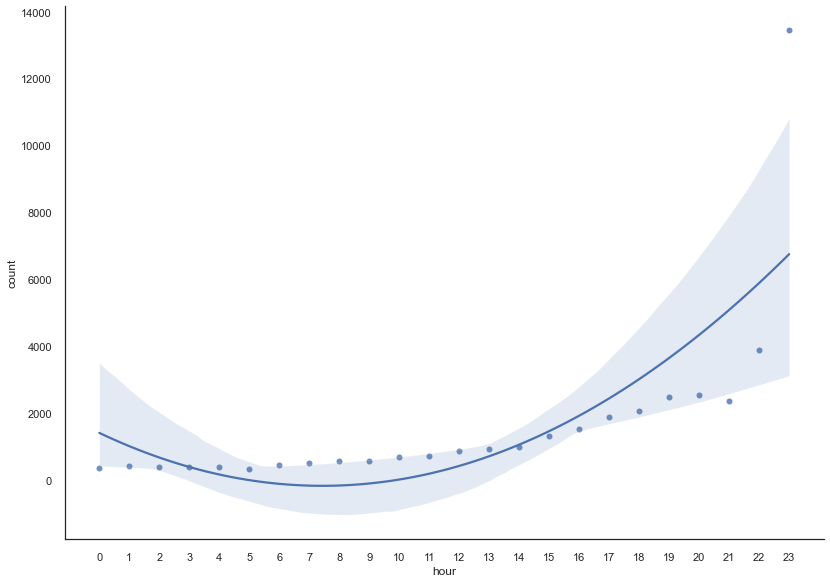

C:\Users\Marco\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Users\Marco\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning:

pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [53]:
sns.set(style="white")
plot = sns.lmplot(x="hour", y="count", order=2,
                  data=df_tweets_hourly, height=8.27, aspect=11.7/8.27)
plt.xticks(np.arange(0, 24, 1))
plt.show()
# plot.savefig('seaborn.png')

fig = px.scatter(df_tweets_hourly, x="hour", y="count",
                 trendline="ols")

fig.update_traces(marker=dict(
    color=colorscale[4]))
fig.show()

In [54]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_tweets_hourly.hour,
        y=df_tweets_hourly['count'],
        marker=dict(color=colorscale[4]),
        mode="lines+markers"
    ))

fig.add_trace(
    go.Bar(
        x=df_tweets_hourly.hour,
        y=df_tweets_hourly['count'],
        marker=dict(color=df_tweets_hourly['count'], coloraxis="coloraxis")
    ))

fig.update_layout(
    coloraxis=dict(colorscale='YlGnBu'),
    showlegend=False,
    title_text="Hourly Tweets Volume",
    uniformtext_minsize=8,
)

fig.show()

In [55]:
def create_wordcloud(text, cmap, name):
    filename = str(name) + ".png"
    mask = np.array(Image.open("twitter.png"))
    stop = set(stopwords.words('english'))
    wc = WordCloud(background_color="white",
                   mask=mask,
                   max_words=300,
                   stopwords=stop,
                   colormap=cmap,
                   repeat=True,
                   )
    wc.generate(str(text))
    wc.to_file(filename)
    path = filename
    display(Image.open(path))

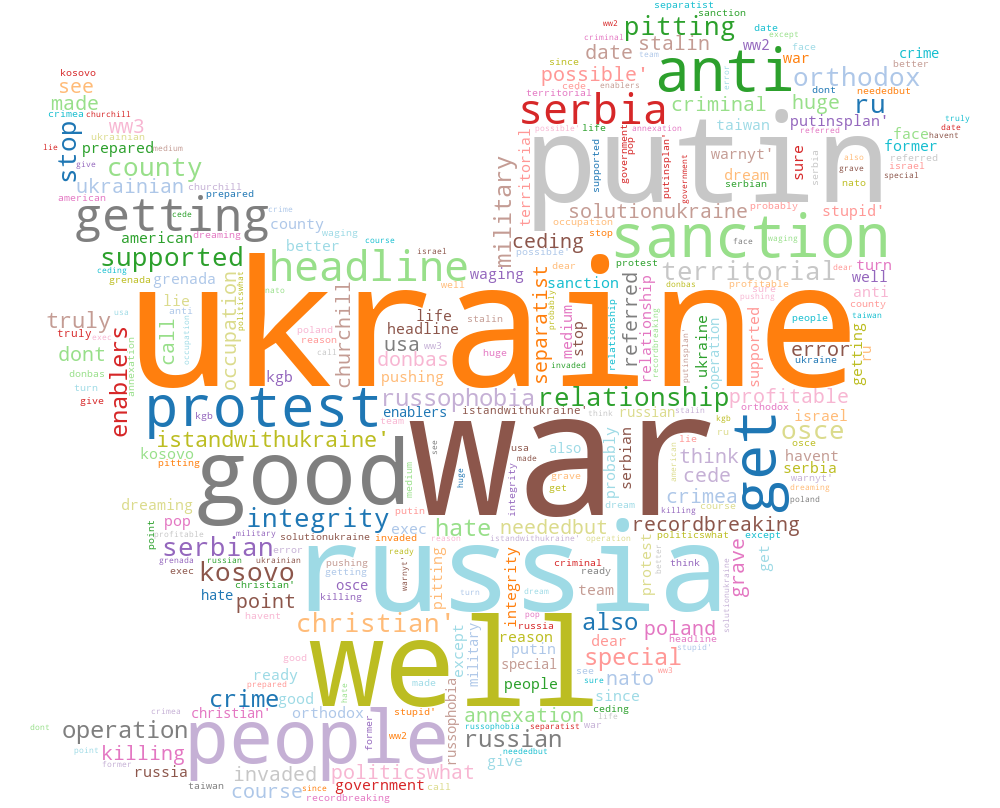

In [56]:
# Creating wordcloud for all tweets
create_wordcloud(tw_list["clean_tweet"].values, 'tab20', "All")

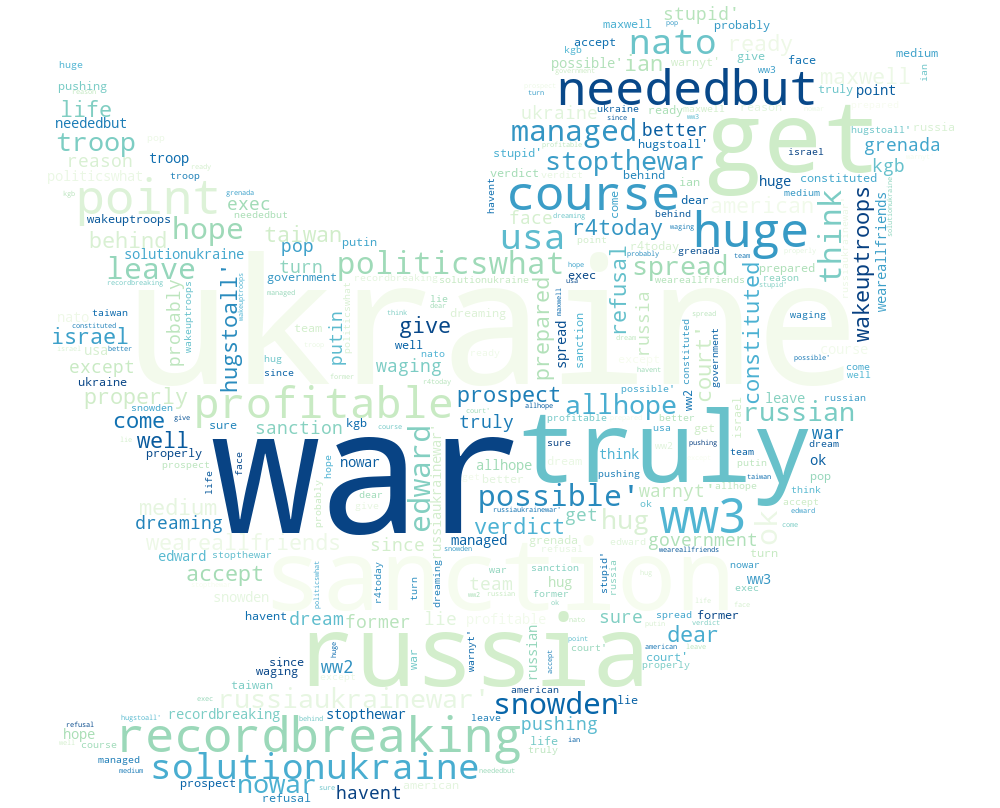

In [57]:
# Creating wordcloud for positive sentiment
create_wordcloud(tw_list[tw_list.sentiment == 'positive']
                 ["clean_tweet"].values, 'GnBu', "Positive")

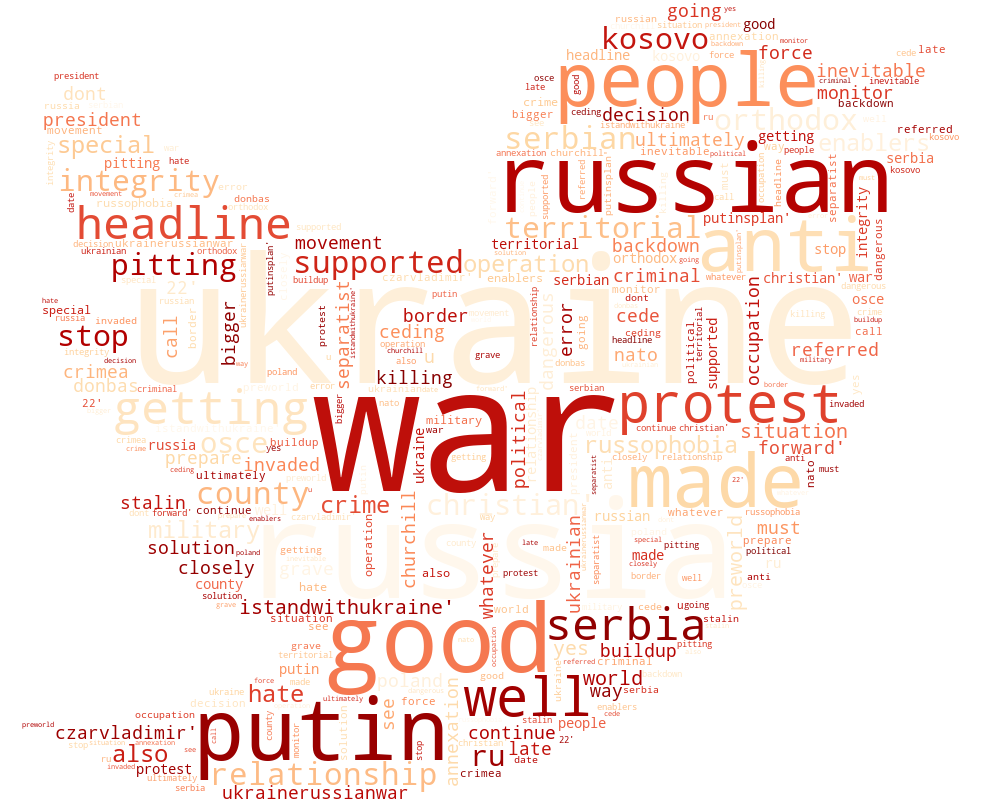

In [58]:
# Creating wordcloud for negative sentiment
create_wordcloud(tw_list[tw_list.sentiment == 'negative']
                 ["clean_tweet"].values, 'OrRd', "Negative")